# Cnn Convolutional neural networks
Las redes convolucionales son ampliamente utilziadas en imagenes por su versatildiad de encontrar mapas de caracteristicas en iamgenes en crudo. Sin embargo, también existen   convolucionales en varais dimensines y no uncaimente ene l amnejo de información de 2 dimensiones.
Un ejemplo claro es en el caos del texto, que puede aplicar una operación convolucional a lo largo de un vector.
Se debe de tener en cuanto varios factores, como es la
* Dimnesión de la convolución: es decir, la operación en qu dimensión se maneja
* Los canales: los canales son la dimensión de caracteristicas de cada punto en la entrada, por ejemplo, en imagenes con los 3 colores de RGB, en texto es la longitud de nustro vocabulario
* Tamaño del kernel: De que tamaño será la aplicación de la operación
* stride: el paso del kernel, cada 1 paso o cada 2 paso en cada dimension
* padding: al aplicar una opeacion convolucional sempre habra un espacio reducido, por lo tanto, para mantener la información tal cual, se utiliza un padding para que al aplciar el proceso convolucional no se reduzaca el tamaño de nuestro conenedor de datos
* Dilation: Que tan separado queremos que los valores de la convolucionale estén 
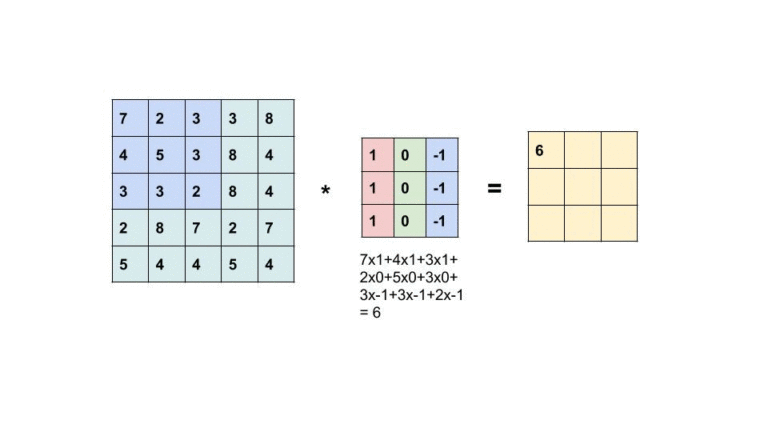

## Surname Vocabulary

In [61]:
import pandas as pd
import torch
import numpy as np
class Vocabulary(object):
    """ Clase a procesar texto y extrar el vocabulario para mappear"""
    def __init__(self,token_to_idx=None,add_unk=True,unk_token="<UNK>"):
        """Args:
            token_to_idx (dict): un mapa pre existen de toknes a indices
            add_unk(bool): un bandera que indica si se añade el token UNK de desconocido
            unk_token(str): el token UNK se añade a el vocabulario
            """
        if token_to_idx is None:
            token_to_idx={}
        self._token_to_idx=token_to_idx
        self._idx_to_token={idx: token
                           for token,idx in self._token_to_idx.items()}
        self._add_unk=add_unk
        self._unk_token=unk_token
        self.unk_index=-1
        if add_unk:
            self.unk_index=self.add_token(unk_token)
    def to_serializable(self):
        """ Retorna un diccionario que puede ser serializado """
        return {"token_to_idx":self._token_to_idx,
               "add_unk":self._add_unk,
               "unk_token":self._unk_token}
    @classmethod
    def from_serializable(cls,contents):
        """instancia el bocabulario desde un diccionario serializado"""
        return cls(**contents)
    def add_token(self,token):
        """
        Actualiza los mapeos de diccionarrios basados en los tokens
        Args:
            token (str): el item a añadir en el vocabulario
        Returns:
            index(int) : el entero correspondiente al token
        """
        if token in self._token_to_idx:
            index=self._token_to_idx[token]
        else:
            index=len(self._token_to_idx)
            self._token_to_idx[token]=index
            self._idx_to_token[index]=token
        return index
    def lookup_token(self,token):
        """ Obtiene el indice asociado con el tokenn de UNK token si el token no está presente,
        Args:
            token (str): el token a observar
        returns :
            index (int) el indices correspondiente al token
        Notes:
               `unk_index` necesita ser entero positivo (habiendo sido añadido al vocabulario) para la funcionalidad desconocidad
               """
        if self._add_unk:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self,index):
        """ Obtiene el token asociado al indice
        Args:
            index (int): el indice a observar
        returns :
            token (str) el token correspondiendte al indices
        Raises:
            KeyError: si el indice no está en el vocabulario
        """
        if index not in self._idx_to_token:
            raise KeyError("El indice (%d)no está en el vocabulario" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):#Refleja la longitudad del vocabulario
        return len(self._token_to_idx)

## Vectorizer

In [69]:
from collections import Counter
import string
class SurnameVectorizer(object):
    """ La clase vectorizer de las cuales, suss coordenadas son las del vocabulario"""
    def __init__(self,surname_vocab,nationality_vocab,max_surname_length):
        self.surname_vocab= surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length
    def vectorize(self,surname):
        """ 
        Crea un vecctor colapsado para la reseña
        Args:
            surname(str) : una reseña
        Returns:
            one_hot_matrix (np.ndarray): la codificacion colapsadad 
        """
        one_hot_matrix_size = (len(self.surname_vocab),self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size,dtype=np.float32)
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index]= 1
        return one_hot_matrix
    @classmethod
    def from_dataframe(cls,surname_df):
        """
        Instancia el vectorizer desde el conjunto de datos del dataframe

        Args:
            review_df (pandas.Dataframe): el conjunto de datos de reseñas
            cuttof(int): el parametro para el filtro de basado en frecuencia
        Returns
        una instacia del ReviewVectorizer
        """
        character_vocab=Vocabulary(unk_token="@")
        nationality_vocab=Vocabulary(add_unk=False)
        max_surname_length=0
        for index,row in surname_df.iterrows():
            max_surname_length = max(max_surname_length,len(row.surname))
            for letter in row.surname:
                character_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(character_vocab,nationality_vocab,max_surname_length)
    @classmethod 
    def from_serializable(cls,contents):
        """
        Instancia una ReviewCectorizer desde un diccionario serializavle
        Args:
                contents(dicT): el diccionario serializable
        Returns:
            Una instancia de ReviewVectorizer class
        """
        review_vocab=Vocabulary.from_serializable(contents["review_vocab"])
        rating_vocab=Vocabulary.from_serializable(contents["rating_vocab"])
        return cls(review_vocab,rating_vocab,contents["max_surname_length"])
    def to_serializable(self):
        """Crea un diccionario seralizable para el chace
        Returns:
            contents(ditc): el diccionario serializable
        """
        return {"review_vocab": self.review_vocab.to_serializable(),
               "rating_vocab": self.rating_vocab.to_serializable(),
               "max_surname_length": self._max_surname_length}


## Surname vecotirzer 

In [70]:

from torch.utils.data import Dataset
class SurnameDataset(Dataset):
    # Se hereda la clase Dataset
    def __init__(self,surname_df,vectorizer):
        """
        Args:
            review_df(pandas.DataFrame): El conjunto de datos
            vectorizer(ReviewVectorizer): vectorizer instacinado desde el conjunto de datos
        """
        self.review_df = surname_df
        self._vectorizer = vectorizer
        self.train_df= self.review_df[self.review_df.split=="train"]
        self.train_size=len(self.train_df)

        self.val_df= self.review_df[self.review_df.split=="val"]
        self.val_size=len(self.val_df)

        self.test_df= self.review_df[self.review_df.split=="test"]
        self.test_size=len(self.test_df)

        self._lookup_dic={'train':(self.train_df,self.train_size),
                         'val':(self.val_df,self.val_size),
                         'test':(self.test_df,self.test_size),
                         }
        self.set_split("train")
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
    @classmethod
    def load_dataset_and_make_vectorizer(cls,review_cls):
        """
        carga el dataset y hacer un nuevo vectorizador desde cero
        args:
                review_cvs(str): ubicacion del dataset
        Returns:
            una instancia de ReviewDataset
        """
        surname_df= pd.read_csv(review_cls)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df,SurnameVectorizer.from_dataframe(train_surname_df))
    def get_vectorizer(self):
        """retorna el vectorizador"""
        return self._vectorizer
    def set_split(self,split="train"):
        """
        Selecciona la division en el conjunto de datos usando una columna en el dataframe
        args:
        split(str):  uno de "train","val","test"
        """
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dic[split]
    def __len__(self):
        return self._target_size
    def __getitem__(self,index):
        """
        El punto primario de entrada como metodo para PyTorch en lso conjuntos de datos
        Args:
        index(int): Es el inice del dato
        Returns:
            Diccionario de las caracterizitcads de los puntos de datos y labels
        """
        row=self._target_df.iloc[index]
        surname_matrix=self._vectorizer.vectorize(row.surname)
        nationality_index=self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'x_data':surname_matrix,
               'y_data':nationality_index}
    def get_num_batches(self,batch_size):
        """
        Dado un tamaño de batch , retorna el numero de batches del conjunto de datos
        Args:
            batch_size(int)
        Returns:
            Numero de batches en el conjuntos
        """
        return len(self)//batch_size

In [71]:
import torch.nn as nn
import torch.nn.functional as F

class SurnameClassifier(nn.Module):
    def __init__(self,initial_num_channels, num_classes, num_channels):
        super(SurnameClassifier,self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels,
                      out_channels=num_channels,
                      kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,kernel_size=3,stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels,out_channels=num_channels, kernel_size=3,stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels,out_channels=num_channels,kernel_size=3),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels,num_classes)
    def forward(self,x_surname, apply_softmax=False):
        """ The forward pass of the classifier

        args: x_sruname (torch.Tensor): an input data tensor 
            x_surname.shape should be (batch, initial_num_channels,
            max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
        returns :
        The resulting tensor:tensor.shae suold be (batch, num_classes)
        """
        features= self.convnet(x_surname).squeeze(dim=2)
        prediction_vector = self.fc(features)
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector,dim=1)
        return prediction_vector

In [72]:
from argparse import Namespace
args=Namespace(
    #Datos y direcciones
    cuda=True,
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_nlp",
    hidden_dim=100,
    num_channels=256,
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=128,
    dropout=0.1
    )

In [73]:
#El conjunto de datos instanciado
import torch.optim as optim
dataset=SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer= dataset.get_vectorizer()

classifier=SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab),
                            num_channels=args.num_channels,
                             num_classes=len(vectorizer.nationality_vocab))
if not torch.cuda.is_available():
    args.cuda=False
args.device= torch.device("cuda" if args.cuda else "cpu")
classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func=nn.CrossEntropyLoss(dataset.class_weights)
optimizer=optim.Adam(classifier.parameters(),lr=args.learning_rate)

In [74]:
def make_train_state(args):
    return { "epoch_index":0,
             "train_loss": [],
             "train_acc":[],
             "val_loss":[],
             "val_acc":[],
             "test_loss":-1,
             "test_acc":-1}
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100
def generate_batches(dataset,batch_size,shuffle=True,
                     drop_last=True,device="cpu"):
    """Una funcion generation la que wrapea ek dataloader de pytorxh. SE asegurarar de que cada tesnor este en un unico dispositivo
    """
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [77]:
from torch.utils.data import DataLoader
train_state=make_train_state(args)
for epoch_index in range(args.num_epochs):
    train_state['epoch_index']=epoch_index
    # Itera sobre nuestro dataset
    #Configura: el generador de batch, la perdidad, el accuracy a 0 y el conjunto de entrenamiento a activo
    dataset.set_split("train")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.train()
    for batch_index,batch_dict in enumerate(batch_generator):
        
        # La rutina de entrenamiento se conforma de 5 pasos

        #paso 1, los gradientes en cero
        optimizer.zero_grad()
        #Paso . calcula la salida
        y_pred=classifier(batch_dict["x_data"].float())
        #paso 3, calcula la perdidad
        loss=loss_func(y_pred,batch_dict["y_data"])
        loss_batch=loss.to("cpu").item()
        running_loss+=(loss_batch-running_loss)/(batch_index+1)
        #paso 4, usa la perdidad para producir el gradiente
        loss.backward()
        #Paso 5, usa el otpimizar para que tomo el paso gradiente
        optimizer.step()

        ##Calcula el accuracy
        acc_batch=compute_accuracy(y_pred,batch_dict["y_data"])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)

    #Iterar sobre el dataset de validacion
    #Configura, el generator de batch, la perdiddad, el accuracy a 0 y modo eval
    dataset.set_split("val")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.eval()
    #Empieza la evaluacion
    for batch_index,batch_dict in enumerate(batch_generator):
        # Paso 1: calcula la salida
        y_pred=classifier(batch_dict["x_data"].float())
        # paso 2, calcula la salida
        loss = loss_func(y_pred,batch_dict['y_data'])
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss)/(batch_index+1)
        #paso 3, calcula el accuracy
        acc_batch= compute_accuracy(y_pred,batch_dict['y_data'])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)

In [79]:
dataset.set_split("test")
batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
running_loss=0.
running_acc=0.
classifier.eval()
print("comienza la evaluacion")
for batch_index,batch_dict in enumerate(batch_generator):
    print("batch: ",batch_index)
    #Compute the output
    y_pred=classifier(batch_dict["x_data"].float())
    # calcula la perdidad
    loss = loss_func(y_pred,batch_dict["y_data"])
    loss_batch= loss.item()
    running_loss += (loss_batch-running_loss)/(batch_index+1)
    #Calcula el accuracy 
    acc_batch= compute_accuracy(y_pred,batch_dict["y_data"])
    running_acc+=(acc_batch-running_acc)/(batch_index+1)
train_state["test_loss"]= running_loss
train_state["test_acc"] = running_acc

comienza la evaluacion
batch:  0
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11


In [80]:
print(train_state["test_acc"])

68.61979166666667


In [82]:
def predict_class(name,classifier, vectorizer):
    vectorized_name=vectorizer.vectorize(name)
    vectorized_name=torch.tensor(vectorized_name).unsqueeze(0)
    result = classifier(vectorized_name,apply_softmax=True)
    probability_values,indices= result.max(dim=1)
    index=indices.item()
    predicted_nationality=vectorizer.nationality_vocab.lookup_index(index)
    probability_value=probability_values.item()
    return {"nationality": predicted_nationality,
            "probability": probability_value
            }

In [83]:
def predict_topk_nationality(name,classifier, vectorizer, k=5):
    vectorize_name = vectorizer.vectorize(name)
    vectorize_name = torch.tensor(vectorize_name).unsqueeze(0)
    prediction_vector=classifier(vectorize_name,apply_softmax=True)

    # retorna el tamaño 1,k
    probability_values,indices= torch.topk(prediction_vector,k=5)
    probability_values=probability_values.detach().numpy()[0]
    indices=indices.detach().numpy()[0]

    results=[]
    for prob_value , index in zip(probability_values,indices):
        nationality=vectorizer.nationality_vocab.lookup_index(index)
        results.append({"nationality": nationality,
                       "probability": prob_value})
    return results

In [97]:
classifier=classifier.to("cpu")

resultado=predict_class("Beet",classifier,vectorizer)
print(resultado)

{'nationality': 'Dutch', 'probability': 0.8427652716636658}


In [93]:

resultado=predict_topk_nationality("Schopenhauer",classifier,vectorizer)
print(resultado)

[{'nationality': 'English', 'probability': np.float32(0.69776785)}, {'nationality': 'Irish', 'probability': np.float32(0.20402443)}, {'nationality': 'Japanese', 'probability': np.float32(0.071494564)}, {'nationality': 'Dutch', 'probability': np.float32(0.026413994)}, {'nationality': 'Chinese', 'probability': np.float32(0.00029404814)}]


# Conexiones residuales
En si consiste en sumar el tensor de entrada de la salida con el tensor resultante
$salida=conv(entrada)+salida$
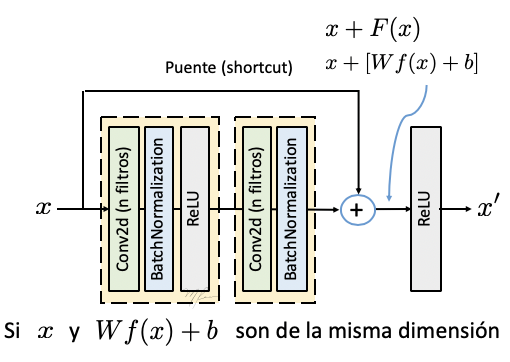
# Normalizaciond de batch
Es la normalización aplicaada por abtch con media 0 y desviacion 1. Se actualiza por abtch y facilita la busqueda de parametros

# Pooling
Es una operacion que permite resumir la alta dimensionalidad d eun maa de caracteristicas a una baja dimensionalidad, por logeneral se puede aplciar medais o maximos o minimos
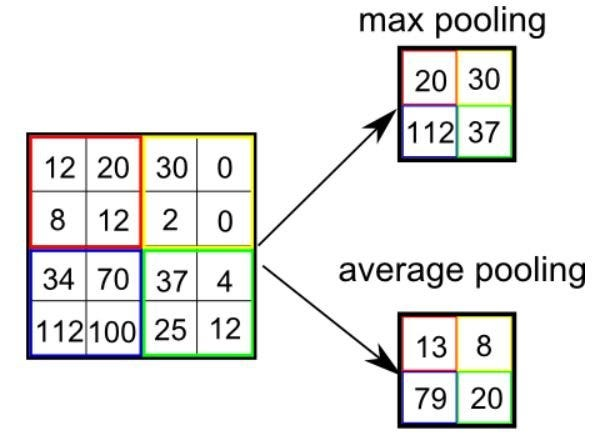